# Heimvorteil im Fußball – EDA (2. Bundesliga)
**Ziel:** Wir laden und bereinigen Spieldaten, beschreiben den Heimvorteil mit
Punkten, Toren und Quoten und dokumentieren unsere ersten Findings. Datenquelle: football-data.co.uk (D2_*.csv)


**Setup**

In [78]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams["figure.figsize"] = (8,4)
DATA_DIR = Path("../data")
RESULTS = Path("../results"); RESULTS.mkdir(exist_ok=True)
FILES = sorted(DATA_DIR.glob("D2_*.csv")) 
FILES


[WindowsPath('../data/D2_18-19.csv'),
 WindowsPath('../data/D2_19-20.csv'),
 WindowsPath('../data/D2_20-21.csv'),
 WindowsPath('../data/D2_21-22.csv'),
 WindowsPath('../data/D2_22-23.csv'),
 WindowsPath('../data/D2_23-24.csv'),
 WindowsPath('../data/D2_24-25.csv'),
 WindowsPath('../data/D2_25-26.csv')]

**Daten laden & bereinigen**
Wir konzentrieren uns zunächst auf Ergebnisdaten (Tore, Punkte). Quoten und Stats ergänzen wir später.

In [79]:
def load_fd(files):
    dfs = []
    for f in files:
        df = pd.read_csv(f)
        df.columns = [c.strip() for c in df.columns]  # Spaltennamen trimmen
        if "Date" in df.columns:
            df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
        dfs.append(df)
    df = pd.concat(dfs, ignore_index=True).sort_values("Date")
    
    # Pflichtspalten absichern
    df = df.dropna(subset=["HomeTeam","AwayTeam","FTR","FTHG","FTAG"])
    return df

df = load_fd(FILES)
df.head()

#Fehlende Werte prüfen
# Anteil fehlender Werte pro Spalte
na_rate = df.isna().mean().sort_values(ascending=False)
na_rate.head(15)


BFDCD    0.991667
LBCH     0.991667
CLCA     0.991667
BVH      0.991667
BVD      0.991667
LBD      0.991667
LBH      0.991667
CLH      0.991667
BVA      0.991667
CLA      0.991667
CLD      0.991667
BFDA     0.991667
BMGMH    0.991667
BMGMA    0.991667
BMGMD    0.991667
dtype: float64

Viele Quoten- und Statistikspalten sind leer (NaN), weil nicht alle Buchmacher oder Statistiken
in jeder Saison/Spiel verfügbar sind. Pflichtspalten (Teams, Tore, Ergebnis) sind aber komplett.


**Grundvariablen vorbereiten**
Wir erzeugen die Variablen **Season**, **HomePoints**, **AwayPoints** und **GD (Goal Difference)**,
die wir für die Heim-/Auswärts-Analysen nutzen.


In [92]:
def season_from_date(dt):
    y = dt.year
    s = y if dt.month >= 7 else y-1
    return f"{str(s)[-2:]}-{str(s+1)[-2:]}"

df["Season"] = df["Date"].apply(season_from_date)
df["HomePoints"] = df["FTR"].map({"H":3,"D":1,"A":0})
df["AwayPoints"] = df["FTR"].map({"H":0,"D":1,"A":3})
df["GD"] = df["FTHG"] - df["FTAG"]  # Tordifferenz Heim-Sicht

# neue Variable: CompletedSeason (alle außer 25-26)
df["CompletedSeason"] = df["Season"].apply(lambda s: s != "25-26")

df[["Season","HomeTeam","AwayTeam","FTHG","FTAG","FTR","HomePoints","AwayPoints","GD","CompletedSeason"]].head()


,Season,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HomePoints,AwayPoints,GD,CompletedSeason
0,18-19,Hamburg,Holstein Kiel,0,3,A,0,3,-3,True
1,18-19,Bochum,FC Koln,0,2,A,0,3,-2,True
2,18-19,Greuther Furth,Sandhausen,3,1,H,3,0,2,True
3,18-19,Regensburg,Ingolstadt,2,1,H,3,0,1,True
4,18-19,Darmstadt,Paderborn,1,0,H,3,0,1,True


In [81]:
# Überblick: Anteil fehlender Werte je Spalte (in %)
na_rate = df.isna().mean().sort_values(ascending=False)
na_rate.head(20), na_rate.tail(10)

# Komplett leere Spalten weg
df = df.dropna(axis=1, how="all")

num_cols = ['FTHG','FTAG','HTHG','HTAG','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR',
            'B365H','B365D','B365A','AvgH','AvgD','AvgA']
for c in (set(num_cols) & set(df.columns)):
    df[c] = pd.to_numeric(df[c], errors='coerce')

    # Pools definieren (was in CSVs wirklich vorhanden ist)
bookies_H = [c for c in df.columns if c.endswith('H') and c[:3] in ['B36','BFD','BMG','BVH','BWH','CLH','LBH','PSH','Max','Avg']]
bookies_D = [c for c in df.columns if c.endswith('D') and c[:3] in ['B36','BFD','BMG','BVD','BWD','CLD','LBD','PSD','Max','Avg']]
bookies_A = [c for c in df.columns if c.endswith('A') and c[:3] in ['B36','BFD','BMG','BVA','BWA','CLA','LBA','PSA','Max','Avg']]

def row_mean(row, cols):
    vals = pd.to_numeric(row[cols], errors='coerce')
    return vals.mean() if vals.notna().any() else np.nan

df['odds_H'] = df.apply(row_mean, axis=1, cols=bookies_H)
df['odds_D'] = df.apply(row_mean, axis=1, cols=bookies_D)
df['odds_A'] = df.apply(row_mean, axis=1, cols=bookies_A)

m = df[['odds_H','odds_D','odds_A']].dropna()
p = 1.0 / m
df.loc[m.index, ['pH','pD','pA']] = (p.T / p.sum(axis=1)).T




coverage = 1 - df[['HS','AS','HST','AST','HC','AC','HY','AY','HR','AR']].isna().mean()
good_stats = coverage[coverage > 0.8].index.tolist()
df_stats = df.dropna(subset=good_stats)

by_season = (df
    .assign(Season=df['Date'].dt.year.where(df['Date'].dt.month>=7, df['Date'].dt.year-1).astype('Int64'))
    .groupby('Season')[['odds_H','HS','HST','HC']].apply(lambda x: 1-x.isna().mean()))
by_season

print(df[['odds_H','odds_D','odds_A','pH','pD','pA']].isna().mean().round(3))
df[['pH','pD','pA']].sum(axis=1).dropna().describe()  # ~1.0

odds_H    0.0
odds_D    0.0
odds_A    0.0
pH        1.0
pD        1.0
pA        1.0
dtype: float64


count    2160.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
dtype: float64

**Überblick / Sanity-Check**

In [82]:
print("Zeilen:", len(df))
print("Fehlende Quoten:", df[["B365H","B365D","B365A"]].isna().any().sum(), "von 3")
print("Anzahl Spiele:", len(df))
print("Zeitraum:", df["Date"].min(), "→", df["Date"].max())
print("Ø Heim-Punkte:", df["HomePoints"].mean().round(2))
print("Ø Auswärts-Punkte:", df["AwayPoints"].mean().round(2))
print("Differenz (Heim-Auswärts):", (df["HomePoints"].mean()-df["AwayPoints"].mean()).round(2))



Zeilen: 2160
Fehlende Quoten: 3 von 3
Anzahl Spiele: 2160
Zeitraum: 2018-08-03 00:00:00 → 2025-08-10 00:00:00
Ø Heim-Punkte: 1.56
Ø Auswärts-Punkte: 1.18
Differenz (Heim-Auswärts): 0.38


Heimteams holen im Schnitt **1.56 Punkte/Spiel**, Auswärtsteams **1.18 Punkte/Spiel**.
Die Differenz beträgt **Δ = 0.38**. → Heimvorteil ist sichtbar.


**Heim vs. Auswärts – Visualisierung**

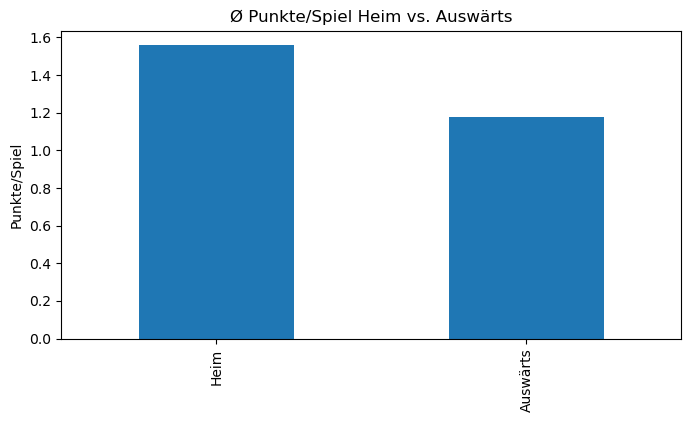

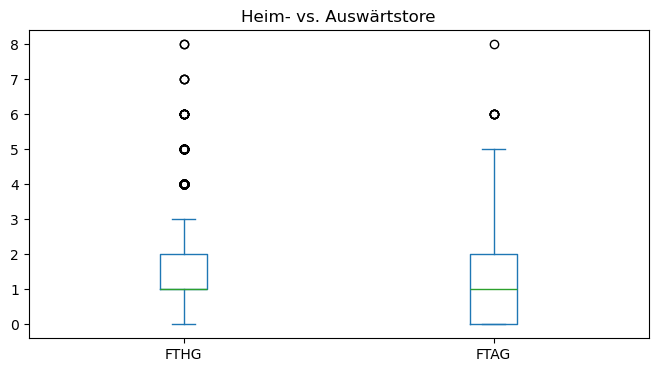

In [83]:
import matplotlib.pyplot as plt

# Punktevergleich
ax = pd.DataFrame({
    "Heim": [df["HomePoints"].mean()],
    "Auswärts": [df["AwayPoints"].mean()]
}).T.rename(columns={0:"Punkte/Spiel"})\
  .plot(kind="bar", legend=False, title="Ø Punkte/Spiel Heim vs. Auswärts")
plt.ylabel("Punkte/Spiel")
plt.show()

# Boxplot Tore
df[["FTHG","FTAG"]].plot(kind="box", title="Heim- vs. Auswärtstore")
plt.show()


Heimteams erzielen im Schnitt mehr Tore als Auswärtsteams. 
Dies bestätigt den Heimvorteil auch auf Torebene.


**Entwicklung über die Saisons**

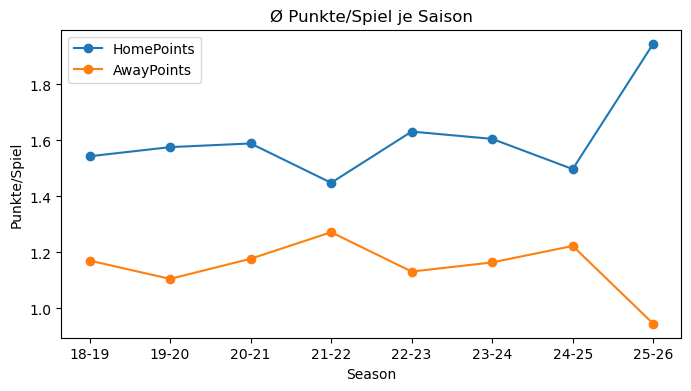

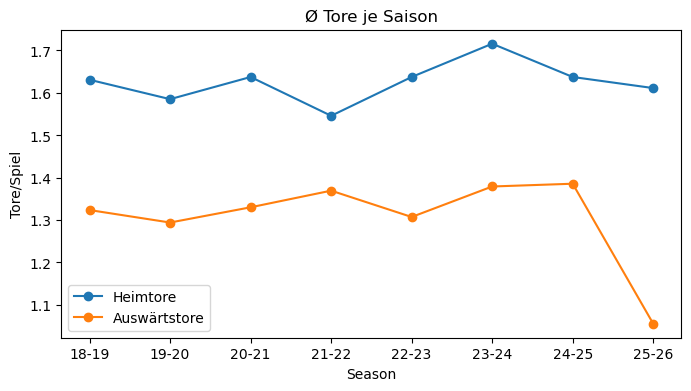

In [89]:
season_ppg = df.groupby("Season")[["HomePoints","AwayPoints"]].mean()
season_ppg.plot(marker="o", title="Ø Punkte/Spiel je Saison")
plt.ylabel("Punkte/Spiel")
plt.show()

season_goals = df.groupby("Season")[["FTHG","FTAG"]].mean()
season_goals.rename(columns={"FTHG":"Heimtore","FTAG":"Auswärtstore"})\
    .plot(marker="o", title="Ø Tore je Saison")
plt.ylabel("Tore/Spiel")
plt.show()



Der Heimvorteil schwankt leicht je Saison. 
- **Vor Corona (bis 19/20):** Heimteams holten stabil ca. 1.55–1.6 Punkte/Spiel bei ~1.6 Toren, während Auswärtsteams auf ~1.15 Punkte/Spiel und ~1.3 Tore kamen → klarer Heimvorteil.  

- **Corona-Phase (20/21–21/22):** Mit Geisterspielen und reduzierten Fans fiel der Heimvorteil sichtbar schwächer aus: Heimpunkte sanken (~1.45 Pkt 21/22), gleichzeitig stiegen Auswärtspunkte und Tore leicht an → Heimvorteil gleicht sich aus.  

- **Nach Corona (ab 22/23):** Mit Rückkehr voller Stadien kehrte der Heimvorteil zurück: Heimteams steigerten Punkte (~1.6–1.9) und Tore (~1.6–1.7), während Auswärtsteams wieder abfielen. → Deutet auf den Einfluss der Zuschauer zurück.

Die Saison 25-26 läuft erst seit wenigen Spieltagen und liefert deshalb nur wenig Aussagekraft.


**Team-Perspektive**
Stärkste Heimteams (nach Ø Punkten/Spiel) sind Heidenheim, Union Berlin, Stuttgart. -> jeweils aufgestiegen


In [ ]:
# Sicherheitsfilter: nur Teams mit "genug" Heimspielen (hier >= 10), optional
team_ppg_f = team_ppg[team_ppg["Spiele"] >= 10].copy()

# Top 5 (höchste PPG_H) – saisonübergreifend
top5_overall = (
    team_ppg_f.sort_values(["PPG_H","Season","Team"], ascending=[False, True, True])
              .head(5)
)
print("TOP 5 overall (highest PPG_H):")
display(top5_overall)

# Flop 5 (niedrigste PPG_H) – saisonübergreifend
bottom5_overall = (
    team_ppg_f.sort_values(["PPG_H","Season","Team"], ascending=[True, True, True])
              .head(5)
)
print("FLOP 5 overall (lowest PPG_H):")
display(bottom5_overall)






TOP 5 overall (highest PPG_H):


,Season,Team,PPG_H,Spiele
80,22-23,Heidenheim,2.352941,17
17,18-19,Union Berlin,2.235294,17
34,19-20,Stuttgart,2.235294,17
36,20-21,Bochum,2.235294,17
74,22-23,Darmstadt,2.235294,17


FLOP 5 overall (lowest PPG_H):


,Season,Team,PPG_H,Spiele
48,20-21,Osnabruck,0.588235,17
63,21-22,Ingolstadt,0.647059,17
4,18-19,Duisburg,0.705882,17
56,21-22,Erzgebirge Aue,0.705882,17
53,20-21,Wurzburger Kickers,0.882353,17


Text(0, 0.5, 'Punkte pro Heimspiel')

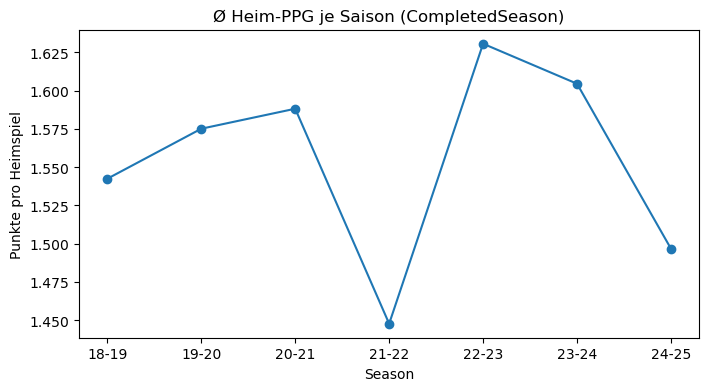

In [95]:
# Flop 3 je Saison
flop3_per_season = (
    team_ppg.sort_values(["Season","PPG_H"], ascending=[True,True])
            .groupby("Season")
            .head(3)
)
flop3_per_season

# Ø Heim-PPG aller Teams je Saison (ohne 25-26)
avg_ppg_season_done = team_ppg.groupby("Season")["PPG_H"].mean()
ax = avg_ppg_season_done.plot(marker="o", title="Ø Heim-PPG je Saison (CompletedSeason)")
ax.set_ylabel("Punkte pro Heimspiel")


In [86]:
team_ppg.to_csv(RESULTS/"team_home_ppg.csv", index=False)


In [88]:
# Tabellen/Charts liegen bereits in ../results
summary = {
    "home_ppg": home_ppg,
    "away_ppg": away_ppg,
    "delta_ppg": home_ppg-away_ppg,
    "n_matches": int(len(df))
}
pd.Series(summary).to_csv(RESULTS/"eda_summary.csv")
